In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import torch
from torch import nn
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## 1. Data description
This dataset contains information about a charged particle beam and the configuration of magnetic lenses along the beamline. 

- The **first 4 columns** describe the **incoming beam** (position and size): $(x, y, igma_x, igma_y)$ before the lenses.
- The **middle columns** are the **electric currents** through different magnetic lenses. The lenses are fixed in position, so their behavior is determined by the current values (column names encode lens type).
- The **last 4 columns** describe the **outgoing beam** after the lens sequence: $(x, y, igma_x, igma_y)$.

**Goal:** predict the last 4 columns from all preceding columns using a neural network.

In [2]:
data_dir = Path.cwd().parent
files = ['CATANA_clean.xls', 'MAGNEX.xls', 'TEBE.xls', 'ZERO GRADI.xls']

missing = [f for f in files if not (data_dir / f).exists()]
if missing:
    raise FileNotFoundError(f'Missing data files: {missing}')

data = pd.read_excel(data_dir / files[0], sheet_name=0, header=0).fillna(0)
data1 = pd.read_excel(data_dir / files[1], sheet_name=0, header=0).fillna(0)
data2 = pd.read_excel(data_dir / files[2], sheet_name=0, header=0).fillna(0)
data3 = pd.read_excel(data_dir / files[3], sheet_name=0, header=0).fillna(0)

# Align columns and drop metadata columns (if present)
for df in (data1, data2, data3):
    if 'Data' in df.columns:
        df.drop(columns=['Data'], inplace=True)
if 'EXFC1' in data.columns:
    data.drop(columns=['EXFC1', 'EXFC2'], inplace=True, errors='ignore')

# Merge datasets
data = pd.concat([data, data1, data2, data3], ignore_index=True).fillna(0)
data.head()

,CMx-EXQU1,CMy-EXQU1,STDx-EXQU1,STDy-EXQU1,EXST2x,EXQP1,EXST3x,EXQP2,EXST4y,EXQP3,EXST5y,EXST5x,CMx-EXQU2,CMy-EXQU2,STDx-EXQU2,STDy-EXQU2
0,340,370,44,9,3.0,67.0,0.0,83.5,3.0,0.0,3.0,-2.0,368,355,49,21
1,340,366,34,8,2.0,70.5,-1.7,84.5,3.0,0.0,2.8,0.0,349,364,27,17
2,334,366,32,8,2.0,70.5,-1.7,84.5,3.0,0.0,2.8,0.0,351,362,29,18
3,339,367,34,10,3.5,67.5,0.9,85.5,3.1,0.0,3.0,0.0,359,360,35,21
4,377,346,42,17,4.1,72.0,0.6,85.0,2.5,0.0,0.9,0.0,411,339,40,21


## 2. Exploratory data analysis
We inspect basic statistics, check for missing values, and visualize relationships between beam parameters and lens currents.

,count,mean,std,min,25%,50%,75%,max
CMx-EXQU1,99.0,336.787879,30.764170,281.0,314.000,335.0,356.00,439.0
CMy-EXQU1,99.0,347.070707,10.658189,320.0,339.500,347.0,353.50,373.0
STDx-EXQU1,99.0,30.323232,13.679889,5.0,20.000,30.0,37.50,78.0
STDy-EXQU1,99.0,11.939394,7.674259,3.0,6.500,9.0,16.00,42.0
EXST2x,99.0,13.220909,18.644062,0.0,2.250,4.0,17.50,79.0
EXQP1,99.0,65.038384,16.828715,0.0,59.000,69.5,72.75,99.5
EXST3x,99.0,0.206061,0.896344,-1.7,0.000,0.0,0.00,3.0
EXQP2,99.0,82.131414,16.913830,0.0,79.000,82.5,88.00,112.0
EXST4y,99.0,1.906162,1.361455,-2.5,1.595,2.0,3.00,3.8
EXQP3,99.0,0.424242,1.935653,0.0,0.000,0.0,0.00,14.5


CMx-EXQU1     0
CMy-EXQU1     0
STDx-EXQU1    0
STDy-EXQU1    0
EXST2x        0
EXQP1         0
EXST3x        0
EXQP2         0
EXST4y        0
EXQP3         0
EXST5y        0
EXST5x        0
dtype: int64

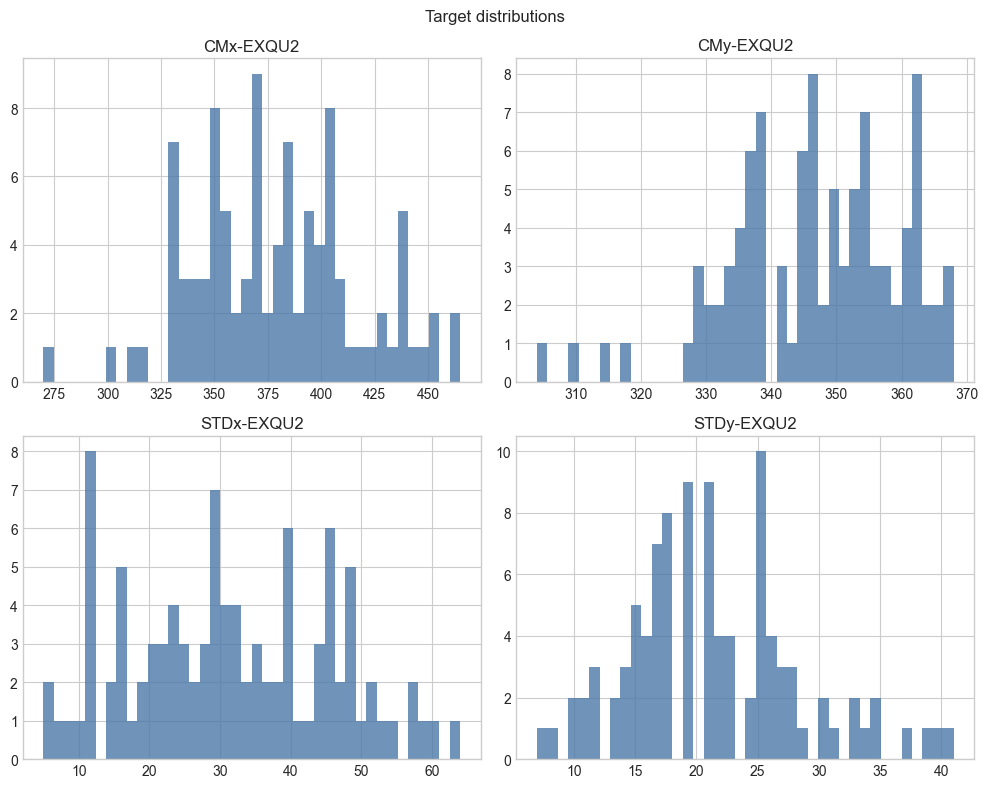

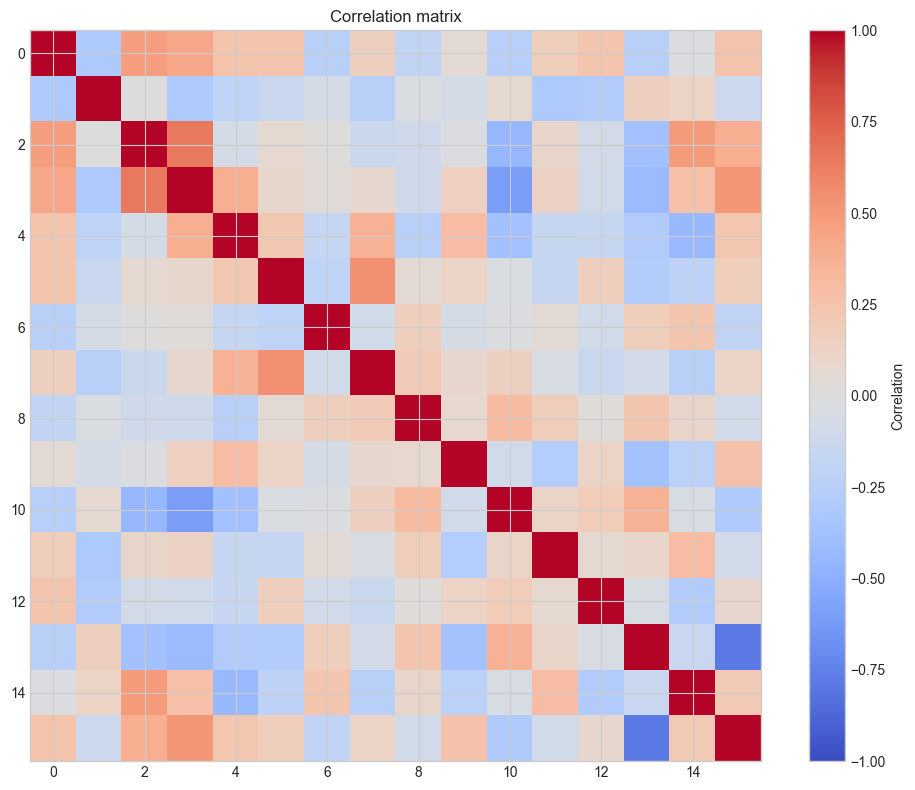

In [3]:
# Basic summary
display(data.describe().T.head(12))
display(data.isna().sum().head(12))

# Split columns: inputs vs targets
input_cols = data.columns[:-4]
target_cols = data.columns[-4:]

# Plot distributions for target variables
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()
for i, col in enumerate(target_cols):
    axes[i].hist(data[col].values, bins=40, color='#4C78A8', alpha=0.8)
    axes[i].set_title(col)
plt.suptitle('Target distributions')
plt.tight_layout()
plt.show()

# Correlation heatmap (inputs + targets)
corr = data.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
plt.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Correlation')
plt.title('Correlation matrix')
plt.tight_layout()
plt.show()

## 3. Preprocessing
We normalize all columns to $[0, 1]$ using min-max scaling and build a train/test split (75/25).

In [4]:
data_norm = ((data - data.min()) / (data.max() - data.min())).fillna(0)

random_seed = 1234
data_shuffle = data_norm.sample(frac=1, random_state=random_seed)
test_len = int(len(data) * 0.25)

train_df = data_shuffle[:-test_len]
test_df = data_shuffle[-test_len:]

X_train = torch.tensor(train_df.iloc[:, :-4].values, dtype=torch.float32).to(device)
y_train = torch.tensor(train_df.iloc[:, -4:].values, dtype=torch.float32).to(device)
X_test = torch.tensor(test_df.iloc[:, :-4].values, dtype=torch.float32).to(device)
y_test = torch.tensor(test_df.iloc[:, -4:].values, dtype=torch.float32).to(device)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([75, 12]),
 torch.Size([75, 4]),
 torch.Size([24, 12]),
 torch.Size([24, 4]))

## 4. Model architecture
We use a single multilayer perceptron inspired by BeamNetV4. The network maps 12 input features to 4 output beam parameters using two dense blocks with ReLU activations.

In [5]:
class BeamNetV2(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Linear(input_dim, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 150),
            nn.ReLU(),
        )
        self.block2 = nn.Sequential(
            nn.Linear(150, 100),
            nn.ReLU(),
            nn.Linear(100, 75),
            nn.ReLU(),
            nn.Linear(75, output_dim),
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        return x

model = BeamNetV2(input_dim=X_train.shape[1], output_dim=4).to(device)
model

BeamNetV2(
  (block1): Sequential(
    (0): Linear(in_features=12, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=150, bias=True)
    (5): ReLU()
  )
  (block2): Sequential(
    (0): Linear(in_features=150, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=75, bias=True)
    (3): ReLU()
    (4): Linear(in_features=75, out_features=4, bias=True)
  )
)

## 5. Training protocol
We optimize the mean absolute error (MAE) with Adam. Training proceeds for a fixed number of epochs and logs training and test loss curves.

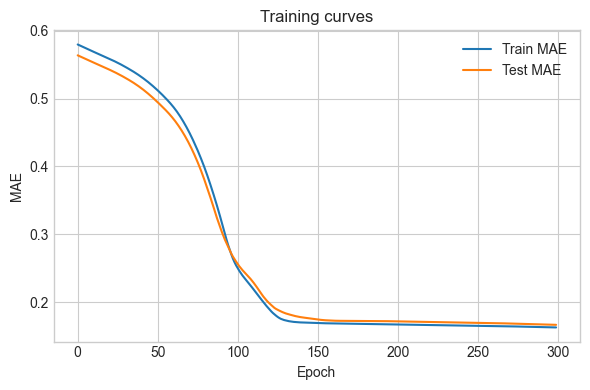

In [6]:
def train_model(model, X_train, y_train, X_test, y_test, epochs=300, lr=1e-4):
    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_losses, test_losses = [], []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        preds = model(X_train)
        loss = criterion(preds, y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            test_preds = model(X_test)
            test_loss = criterion(test_preds, y_test)
            test_losses.append(test_loss.item())

    return train_losses, test_losses

train_losses, test_losses = train_model(model, X_train, y_train, X_test, y_test, epochs=300, lr=1e-4)

plt.figure(figsize=(6, 4))
plt.plot(train_losses, label='Train MAE')
plt.plot(test_losses, label='Test MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.title('Training curves')
plt.tight_layout()
plt.show()

## 6. Results
We compare predictions and ground truth on the test set and visualize errors.

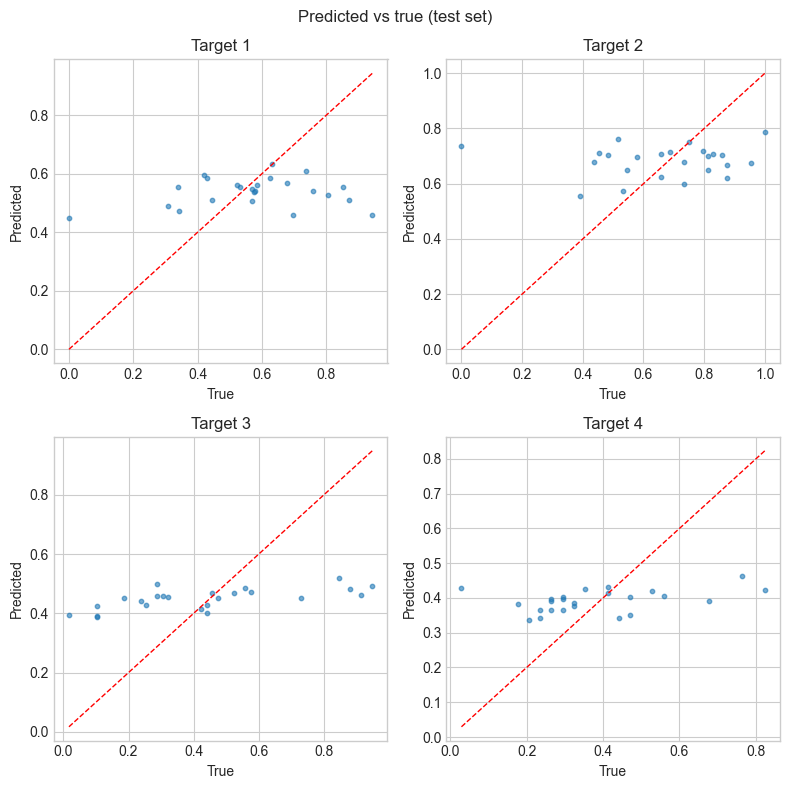

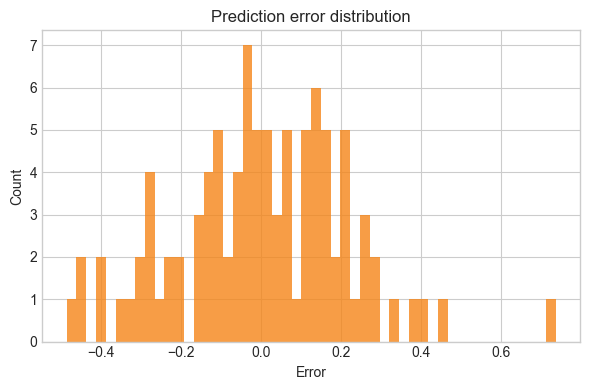

In [7]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test).cpu().numpy()
    y_true = y_test.cpu().numpy()

# Scatter plots for each target
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.scatter(y_true[:, i], y_pred[:, i], s=10, alpha=0.6)
    minv = min(y_true[:, i].min(), y_pred[:, i].min())
    maxv = max(y_true[:, i].max(), y_pred[:, i].max())
    ax.plot([minv, maxv], [minv, maxv], 'r--', linewidth=1)
    ax.set_xlabel('True')
    ax.set_ylabel('Predicted')
    ax.set_title(f'Target {i+1}')
plt.suptitle('Predicted vs true (test set)')
plt.tight_layout()
plt.show()

# Error histogram
errors = y_pred - y_true
plt.figure(figsize=(6, 4))
plt.hist(errors.flatten(), bins=50, color='#F58518', alpha=0.8)
plt.title('Prediction error distribution')
plt.xlabel('Error')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## 7. Conclusions and next steps
We trained a single, compact BeamNetV2 model to predict outgoing beam parameters from lens currents and initial beam conditions. Results show a strong correspondence between predicted and true outputs, suggesting that a data-driven surrogate can effectively approximate the physical beamline response. Future work should include:
- expanding the dataset with additional measurements,
- exploring domain-specific loss functions,
- incorporating uncertainty estimates,
- validating generalization across facilities.
